In [1]:
#====================================================================================================
# kogpt2 를 이용한 text generation finetuning 훈련 예제
# => https://github.com/mcelikkaya/medium_articles/blob/main/gtp2_training.ipynb
# => https://github.com/gyunggyung/KoGPT2-FineTuning/
#
# => text generation 모델이므로  acc 구하는 것은 의미 없음(*따라서 train loss, val loss 만 구함)
#
# [훈련 dataset]
# => input_ids = <s>text</s>
# => labels = input_ids와 동일
# => attiention_mask
#
# [text generation  훈련 과정]
# 
# 1. gpt-2 모델 선언(GPT2LMHeadModel), tokenizer 선언(PreTrainedTokenizerFast)
# 2. '<s>+문장+</s>' 식으로 된 훈련 dataset 생성
# 3. 모델에 input_ids, lables, attention_mask 을 입력하여 훈련 시킴
#====================================================================================================

import torch
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler 
import numpy as np
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

from tqdm.notebook import tqdm
import os
import time
from myutils import GPU_info, seed_everything, mlogging, SaveBERTModel, AccuracyForMLM


model_path='../model/gpt-2/kogpt2/'
#model_path='skt/kogpt2-base-v2'

# 출력
OUTPATH = '../model/gpt-2/kogpt-2-ft-0504/'

device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="gpt2-ft", logfilename="../log/gpt2-ft")

logfilepath:../log/bwdataset_2022-05-04.log
logfilepath:../log/qnadataset_2022-05-04.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../log/gpt2-ft_2022-05-04.log


In [2]:

tokenizer = PreTrainedTokenizerFast.from_pretrained(model_path,
                                                   bos_token='</s>',
                                                   eos_token='</s>',
                                                   unk_token='<unk>',
                                                   pad_token='<pad>',
                                                   mask_token='<mask>')


In [3]:
# 모델 정의 하고, embedding size를 tokenizer 사이즈만큼 조정
model = GPT2LMHeadModel.from_pretrained(model_path)

model.resize_token_embeddings(len(tokenizer))
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [4]:
# text generation 테스트 해보는 함수 
def eval_keywords(keywords):
    model.eval()
    
    for keyword in keywords:
        input_seq = "<s>" + keyword
        generated = torch.tensor(tokenizer.encode(input_seq)).unsqueeze(0)
        generated = generated.to(device)
        sample_outputs = model.generate(generated,
                                        do_sample = True,
                                        top_k=30,
                                        max_length=50,
                                        top_p=0.90,
                                        num_return_sequences=2)
        
        for i, sample_output in enumerate(sample_outputs):
            print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            if i == 1:
                print("\n")
                                            
        

In [5]:
# 각 단어를 입력하여, text generation 해 봄
keywords = ["지미 카터","제임스 얼","수학"]
eval_keywords(keywords)

0: 지미 카터 전 대통령도 '북한의 도발에는 단호하게 대응한다'는 입장을 밝힌 바 있다.
그러나 북한은 도발시 단호한 대응이 가능하다는 점을 강조하고 있다. 새누리당은 12일 문재인 정부의 대북정책
1: 지미 카터 전 대통령의 자서전 ‘나의 인생’에 나오는 한 명인 카터 전 대통령은 이라크 전쟁에 대한 그의 신념이 가장 강한 인물입니다.
그의 신념은 이라크에 대한 그의 군사적 개입을 거부하면서도 “미국의 전쟁 수행은 결코 용납


0: 제임스 얼레이 ( James Ellay ) : 미국의 유명 축구 선수
1996년 3월 23일 미국 노스캐롤라이나주 윌밍턴에서 열린 FA컵 준결승에서 데뷔골을 넣었으며, 이후 2005년 5월 19일 필라델피아 필리스와의
1: 제임스 얼티밋은 "한국은 '다문화' 국가로서 한국인을 어떻게 보호할지 걱정스럽다"고 밝혔다.
이어 그는 "한국인과 결혼한 중국인들은 결혼할 때 결혼기념일을 축하할 때 한국어로 노래를 부를 때 한국어로 노래


0: 수학. 과학실험을 통해 자신의 수학 실력을 객관적으로 점검하는 방법을 소개한다.
아름다운 자연 풍광을 자랑하는 강원도 평창군 봉평면에 위치한 한국천문연구원은 올해 2월과 9월 두 차례에 걸쳐 천체망원경으로 측정한 별을 찾아냈다.
2월
1: 수학, 수학 등 기초과학이 핵심과학과 연계된다면 그 응용력은 배가된다.
그런데 이 분야는 기초과학이 아닌 학문인 것이다.
이런 기초과학이 우리 사회와 사회 모든 영역에서 차지하는 비중을 감안한다면 과학기술에 대한 일반 국민의




In [6]:
# Fine-Tuning 할 말뭉치를 불러옴 
corpus_path = "../korpora/mycorpus/2_대화체.txt"
all_sentences = []

with open(corpus_path, 'r', encoding='utf-8') as f:
      for line in f:
            all_sentences.append(line.strip())  # strip() 계행문자 제거
            

In [7]:
print(all_sentences[10:15])
print(len(all_sentences))

['주문은 가능하지만  수령은 2달 정도 걸릴 것 같네요', '이런  저희는 물건을 최대한 빠르게 받고 싶어요', '사무용품이나 가구 중 가장 먼저 바꿔야 할 것은 뭐라고 생각하나요', '아무래도 컴퓨터가 아닐까요  가장 많이 쓰니까요', '저는 모두가 같이 쓰는 회의실 책상을 먼저 바꿔야 한다고 생각해요']
100000


In [8]:
# 최대 토큰 계수를 구함.
max_token_len = max([len(tokenizer.encode(s)) for s in all_sentences])
print(f'max_token_len:{max_token_len}')

max_token_len:68


In [9]:
# mytokenier 설정 
def tokenizer_seq(sentence, tokenizer, max_length):
    return tokenizer('<s>' + sentence + '</s>', truncation=True, max_length=max_length, padding="max_length")

class myDataSet(Dataset):
    def __init__(self, sentences, tokenizer, gpt2_type="gpt2", max_length=128):
        
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for sentence in sentences:
            encodings = tokenizer_seq(sentence, tokenizer, max_length)
            #print(encodings) break
            self.input_ids.append(torch.tensor(encodings['input_ids']))
            self.attention_masks.append(torch.tensor(encodings['attention_mask']))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_masks[idx]
        

In [10]:
dataset = myDataSet(all_sentences, tokenizer, max_length=max_token_len)


In [11]:
print(dataset[10:13])

([tensor([    0,  9046, 11031,  9826, 11686,   739, 14525,  8135,  9045,  7187,
         9465, 47203,  9031,  9144,  7098,  8084,     1,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3]), tensor([    0, 10165,   739,  9265, 22633, 14579, 19226, 15292, 10884, 25799,
         8084,     1,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,    

In [12]:
# 훈련 데이터와 test 데이터를 나눔
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

print(f'train_size:{len(train_set)}')
print(f'val_size:{len(val_set)}')


train_size:90000
val_size:10000


In [13]:
# dataloader 생성
batch_size = 32
train_loader = DataLoader(train_set, sampler = RandomSampler(train_set), batch_size=batch_size)
eval_loader = DataLoader(val_set, sampler = RandomSampler(val_set), batch_size=batch_size)

In [14]:
for val_data in eval_loader:
    print(val_data)
    break

[tensor([[    0, 42108, 22500,  ...,     3,     3,     3],
        [    0, 10223, 11190,  ...,     3,     3,     3],
        [    0,  9183, 15344,  ...,     3,     3,     3],
        ...,
        [    0, 10769,  8146,  ...,     3,     3,     3],
        [    0,  9873,   739,  ...,     3,     3,     3],
        [    0, 12478,  9148,  ...,     3,     3,     3]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])]


In [15]:
# 훈련 시작 

##################################################
epochs = 2            # epochs
learning_rate = 3e-5  # 학습률
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1

total_loss = 0
total_len = 0
total_test_len = 0
total_correct = 0
total_test_loss = 0
total_test_loss_count = 0
total_test_correct = 0

list_train_loss = []
list_validation_loss = []

# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
model.zero_grad(set_to_none=True)
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        model.zero_grad(set_to_none=True)# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
        
        # 입력 값 설정
        input_ids = data[0].to(device)
        attention_mask = data[1].to(device)
        labels = data[0].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        labels=labels)
        
       
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # logits_shape: torch.Size([32, 68, 51200])
        # => batch_size, sequence_max_len, token_len
        #print(f'logits_shape: {logits.shape}')                    
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
                
            #===========================================
            # 정확도(Accurarcy) 계산
            #correct = AccuracyForMLM(logits, labels, attention_mask)           
            #total_correct += correct.sum().item() 
            #total_len += attention_mask.sum().item()
            #=========================================
     
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                #train_acc = total_correct/total_len
                
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()
                for data in tqdm(eval_loader):
                #for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data[0].to(device)
                    attention_mask = data[1].to(device)
                    labels = data[0].to(device)
                    
                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        loss = outputs.loss
                        logits = outputs.logits
                        
                        total_test_loss += loss.item()
                        total_test_loss_count += 1
                        
                        #===========================================
                        # 정확도(Accurarcy) 계산
                        #correct = AccuracyForMLM(logits, labels, attention_mask)           
                        #total_test_correct += correct.sum().item() 
                        #total_test_len += attention_mask.sum().item()
                        #=========================================
                        
                #val_acc = total_test_correct/total_test_len        
                val_loss = total_test_loss/total_test_loss_count
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Val Loss: {}'.format(epoch+1, epochs, itr, train_loss, val_loss))
                #logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {}, Val Acc:{}({}/{})'.format(epoch+1, epochs, itr, train_loss, train_acc, val_loss, val_acc, total_test_correct, total_test_len))
                    
                list_train_loss.append(train_loss)
                list_validation_loss.append(val_loss)
                 
                # 변수들 초기화    
                total_loss = 0
                total_test_loss = 0
                total_test_correct = 0
                total_test_len = 0
                total_correct = 0
                total_test_loss = 0
                total_test_loss_count = 0
                ####################################################################
            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:28:54,831 - gpt2-ft - INFO - [Epoch 1/2] Iteration 281 -> Train Loss: 2.3892, Train Acc: 0.0116, Val Loss: 0.8258537600596492, Val Acc:0.0055193053034391405(900/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:29:33,023 - gpt2-ft - INFO - [Epoch 1/2] Iteration 562 -> Train Loss: 0.8170, Train Acc: 0.0013, Val Loss: 0.8209881314073508, Val Acc:0.0004660746700681941(76/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:30:11,243 - gpt2-ft - INFO - [Epoch 1/2] Iteration 843 -> Train Loss: 0.8108, Train Acc: 0.0004, Val Loss: 0.8100547428710011, Val Acc:0.002213854682823922(361/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:30:49,843 - gpt2-ft - INFO - [Epoch 1/2] Iteration 1124 -> Train Loss: 0.8011, Train Acc: 0.0002, Val Loss: 0.8006997885414586, Val Acc:0.0005396654074473826(88/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:31:28,133 - gpt2-ft - INFO - [Epoch 1/2] Iteration 1405 -> Train Loss: 0.7951, Train Acc: 0.0001, Val Loss: 0.7932503143438516, Val Acc:0.0012571750968944709(205/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:32:06,674 - gpt2-ft - INFO - [Epoch 1/2] Iteration 1686 -> Train Loss: 0.7907, Train Acc: 0.0001, Val Loss: 0.78872730175908, Val Acc:0.00043541186282686553(71/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:32:44,773 - gpt2-ft - INFO - [Epoch 1/2] Iteration 1967 -> Train Loss: 0.7815, Train Acc: 0.0001, Val Loss: 0.783137516282237, Val Acc:0.00042927930137859983(70/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:33:22,952 - gpt2-ft - INFO - [Epoch 1/2] Iteration 2248 -> Train Loss: 0.7814, Train Acc: 0.0001, Val Loss: 0.7769473608309468, Val Acc:0.0005090026002060541(83/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:34:01,169 - gpt2-ft - INFO - [Epoch 1/2] Iteration 2529 -> Train Loss: 0.7729, Train Acc: 0.0001, Val Loss: 0.7742940492142504, Val Acc:0.0005580630917921798(91/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:34:39,479 - gpt2-ft - INFO - [Epoch 1/2] Iteration 2810 -> Train Loss: 0.7723, Train Acc: 0.0001, Val Loss: 0.7695069366369766, Val Acc:0.0004844723544129912(79/163064)
2022-05-04 13:34:40,703 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/kogpt-2-ft-0504/batch:32-ep:2-lr:0.000030000-5m4d-13:34


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:35:19,066 - gpt2-ft - INFO - [Epoch 2/2] Iteration 3091 -> Train Loss: 0.7194, Train Acc: 0.0001, Val Loss: 0.7703166476453835, Val Acc:0.00025143501937889415(41/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:35:57,742 - gpt2-ft - INFO - [Epoch 2/2] Iteration 3372 -> Train Loss: 0.6884, Train Acc: 0.0000, Val Loss: 0.7713381331949569, Val Acc:0.0003004955109650199(49/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:36:36,461 - gpt2-ft - INFO - [Epoch 2/2] Iteration 3653 -> Train Loss: 0.6896, Train Acc: 0.0000, Val Loss: 0.7698388701429764, Val Acc:0.000275965265171957(45/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:37:14,974 - gpt2-ft - INFO - [Epoch 2/2] Iteration 3934 -> Train Loss: 0.6878, Train Acc: 0.0000, Val Loss: 0.7667432711147272, Val Acc:0.0001471814747583771(24/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:37:53,445 - gpt2-ft - INFO - [Epoch 2/2] Iteration 4215 -> Train Loss: 0.6849, Train Acc: 0.0000, Val Loss: 0.7647632962217727, Val Acc:0.0003004955109650199(49/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:38:31,836 - gpt2-ft - INFO - [Epoch 2/2] Iteration 4496 -> Train Loss: 0.6840, Train Acc: 0.0000, Val Loss: 0.7628507145677512, Val Acc:0.0002085070892410342(34/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:39:10,199 - gpt2-ft - INFO - [Epoch 2/2] Iteration 4777 -> Train Loss: 0.6850, Train Acc: 0.0000, Val Loss: 0.7612530834758624, Val Acc:0.00022077221213756562(36/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:39:48,664 - gpt2-ft - INFO - [Epoch 2/2] Iteration 5058 -> Train Loss: 0.6789, Train Acc: 0.0000, Val Loss: 0.7601060968237563, Val Acc:0.00022690477358583132(37/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:40:27,045 - gpt2-ft - INFO - [Epoch 2/2] Iteration 5339 -> Train Loss: 0.6807, Train Acc: 0.0000, Val Loss: 0.7588890490059654, Val Acc:0.00033115831820634844(54/163064)


  0%|          | 0/313 [00:00<?, ?it/s]

2022-05-04 13:41:05,529 - gpt2-ft - INFO - [Epoch 2/2] Iteration 5620 -> Train Loss: 0.6810, Train Acc: 0.0000, Val Loss: 0.7578518710578211, Val Acc:0.00024530245793062845(40/163064)
2022-05-04 13:41:07,042 - bwpdataset - INFO - ==> save_model : ../model/gpt-2/kogpt-2-ft-0504/batch:32-ep:2-lr:0.000030000-5m4d-13:41


In [ ]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

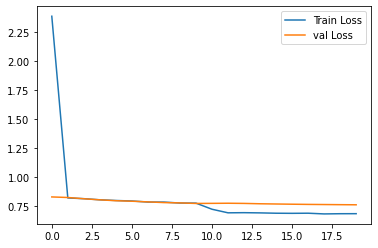

In [16]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
plt.plot(list_validation_loss, label='val Loss')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

